In [1]:
%matplotlib inline
from sklearn import svm, cross_validation
from sklearn.cross_validation import LeaveOneOut
import numpy as np
import pandas as pd
from scipy import interp, stats
import pylab as pl
from sklearn.metrics import roc_curve, auc, recall_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFdr, f_classif, SelectPercentile, SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import random
import matplotlib.pyplot as plt

In [2]:
def draw_ROC_CV(X_new, y, n_folds, classifier, clf_name):
    
    auc_list=[]
    
    pl.rcParams['figure.figsize'] = (10.0, 8.0)
    pl.clf()
    cv = StratifiedKFold(y, n_folds=n_folds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
#        classifier=svm.SVC(kernel= 'rbf', probability=True)
        fit = classifier.fit(X_new[train], y[train])
        probas_ = fit.predict_proba(X_new[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
#        print fpr,tpr
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
        pl.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
#    print probas_
    pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    pl.xlim([-0.05, 1.05])
    pl.ylim([-0.05, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(clf_name+' ROC-AUC')
    pl.legend(loc="lower right")
    pl.savefig(clf_name+' ROC-AUC.pdf', format='pdf')
    pl.show()
    return auc_list

##Loading RBP list

In [3]:
newRBP_table=pd.read_table('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/merged_list_figures/merged_rbp_list_wh.txt', sep=',', index_col=0)
for rix, row in newRBP_table.iterrows():
    if pd.isnull(row['gene name']):
        newRBP_table.loc[rix, 'gene name']=row['Gene Symbol']

newRBP_table_v2=newRBP_table
newRBP_table=newRBP_table[newRBP_table['gene name'].apply(pd.notnull)]
RBP_set=set(newRBP_table['gene name'])


In [22]:
#print newRBP_table_v2[newRBP_table_v2['gene name'].apply(pd.isnull)]
#print len(newRBP_table_v2)
#print len(newRBP_table)
#print len(RBP_set)
'XK' in RBP_set

False

In [4]:
print len(RBP_set)
print newRBP_table.shape

1786
(1816, 3)


<h2>Loading PPI features table</h2>

In [4]:
PPI_feature_label_mat=pd.read_table('PPI_feature_label_table.xls', index_col=0)
#PPI_feature_label_mat['primary_RBP_ratio']=PPI_feature_label_mat['RBP_neighbor_counts']*1.0/PPI_feature_label_mat['1st_neighbor_counts']
#PPI_feature_label_mat['secondary_RBP_ratio']=PPI_feature_label_mat['RBP_2nd_neighbor_counts']*1.0/PPI_feature_label_mat['2nd_neighbor_counts']
PPI_feature_label_mat.loc['C1orf131']

RBP_neighbor_counts           0.000000
1st_neighbor_counts           5.000000
RBP_2nd_neighbor_counts       9.000000
2nd_neighbor_counts          67.000000
RBP_3rd_neighbor_counts     150.000000
3rd_neighbor_counts        1063.000000
primary_RBP_ratio             0.000000
secondary_RBP_ratio           0.134328
tertiary_RBP_ratio            0.141110
RBP_flag                      0.000000
Name: C1orf131, dtype: float64

In [5]:
PPI_feature_label_mat['RBP_flag']=0
for rix, row in PPI_feature_label_mat.iterrows():
    if(rix in RBP_set):
        PPI_feature_label_mat.loc[rix,'RBP_flag']=1
        
PPI_feature_label_mat

,RBP_neighbor_counts,1st_neighbor_counts,RBP_2nd_neighbor_counts,2nd_neighbor_counts,RBP_3rd_neighbor_counts,3rd_neighbor_counts,primary_RBP_ratio,secondary_RBP_ratio,tertiary_RBP_ratio,RBP_flag
Sept1,0,13,14,189,210,3269,0.000000,0.074074,0.064240,0
Sept10,1,18,71,392,6022,17012,0.055556,0.181122,0.353985,0
Sept11,1,9,63,221,5769,11563,0.111111,0.285068,0.498919,0
Sept12,0,11,11,192,269,4864,0.000000,0.057292,0.055304,0
Sept14,0,5,4,83,69,1413,0.000000,0.048193,0.048832,0
Sept2,1,16,68,332,5840,14634,0.062500,0.204819,0.399071,0
Sept3,1,21,72,365,5848,16171,0.047619,0.197260,0.361635,0
Sept4,0,8,5,123,85,1959,0.000000,0.040650,0.043389,0
March5,0,4,11,100,693,4514,0.000000,0.110000,0.153522,0
Sept5,1,9,63,221,5769,11563,0.111111,0.285068,0.498919,0


In [6]:
sum(PPI_feature_label_mat['RBP_flag'])

1371

In [4]:
##original data matrix 
X=np.array(PPI_feature_label_mat[['RBP_neighbor_counts','RBP_2nd_neighbor_counts']])
X_ratio=np.array(PPI_feature_label_mat[['primary_RBP_ratio','secondary_RBP_ratio']])
X_num_ration=np.array(PPI_feature_label_mat[['RBP_neighbor_counts','RBP_2nd_neighbor_counts','primary_RBP_ratio','secondary_RBP_ratio']])
y=np.array(PPI_feature_label_mat['RBP_flag'])

<h2>Undersample the non-RBP class, and generate the dataset for training and testing</h2>

In [7]:
##(randomly pick), undersampling of the majority class (i.e. the non-RBP class)
Xy_RBP_df=(PPI_feature_label_mat[PPI_feature_label_mat['RBP_flag']==1])
Xy_nonRBP_df=(PPI_feature_label_mat[PPI_feature_label_mat['RBP_flag']==0])
idx_nonRBP=np.random.randint(0, len(Xy_nonRBP_df), size=len(Xy_RBP_df))
Xy_nonRBP_df_undersampled=Xy_nonRBP_df.iloc[idx_nonRBP]
Xy_undersampled_df=pd.concat([Xy_RBP_df,Xy_nonRBP_df_undersampled])
X_undersampled=np.array(Xy_undersampled_df[['RBP_neighbor_counts','RBP_2nd_neighbor_counts']])
X_ratio_undersampled_1level=np.array(Xy_undersampled_df[['primary_RBP_ratio']])
X_ratio_undersampled_2level=np.array(Xy_undersampled_df[['primary_RBP_ratio','secondary_RBP_ratio']])
X_ratio_undersampled_3level=np.array(Xy_undersampled_df[['primary_RBP_ratio','secondary_RBP_ratio','tertiary_RBP_ratio']])
X_num_ratio_undersampled=np.array(Xy_undersampled_df[['RBP_neighbor_counts','RBP_2nd_neighbor_counts','primary_RBP_ratio','secondary_RBP_ratio']])
y_undersampled=np.array(Xy_undersampled_df['RBP_flag'])
Xy_undersampled_prot_names=Xy_undersampled_df.index
y_undersampled_shuffled=np.copy(y_undersampled)
random.shuffle(y_undersampled_shuffled)

<h2>Try different classifiers </h2>

In [7]:
def get_specificity(y_true,y_pred):
    TN_counts=0
    FP_counts=0
    for i in range(0, len(y_pred)):
        if(y_pred[i]==0 and y_true[i]==0):
            TN_counts=TN_counts+1
        elif(y_pred[i]==1 and y_true[i]==0):
            FP_counts=FP_counts+1

    return TN_counts*1.0/(TN_counts+FP_counts)

In [8]:
def get_FP_FN(y_true, y_pred, prot_names):
    """
    get the proteins' names which are misclassified. e.g. False positive samples and False negative samples
    """
    FP_set=set([])
    FN_set=set([])
    for i in range(0, len(y_pred)):
        if(y_pred[i]==1 and y_true[i]==0):
            FP_set.add(prot_names[i])
        elif(y_pred[i]==0 and y_true[i]==1):
            FN_set.add(prot_names[i])
            
    
    return FP_set, FN_set

<h2>The performance of each classifiers for ROC-AUC

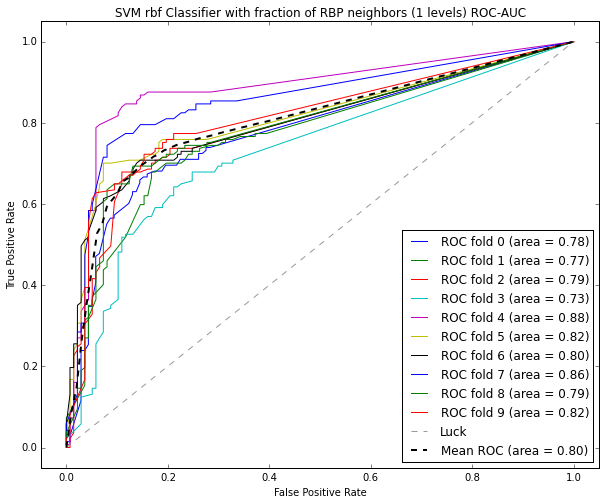

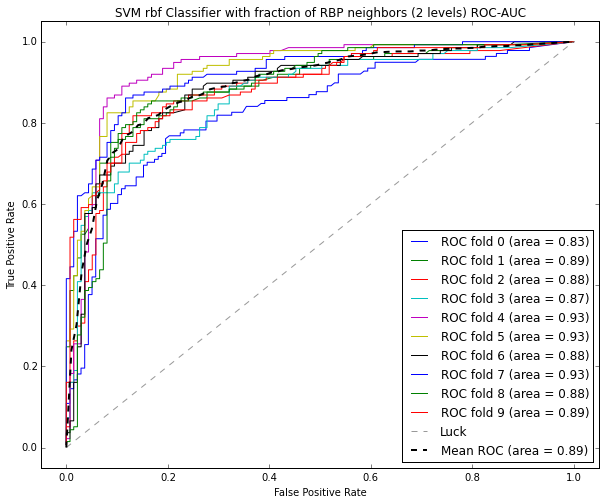

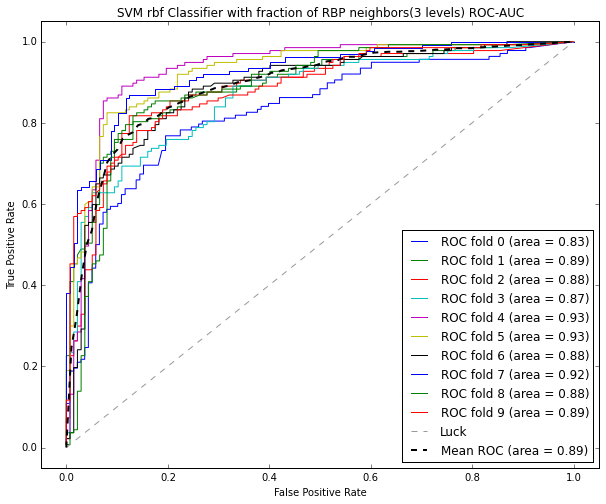

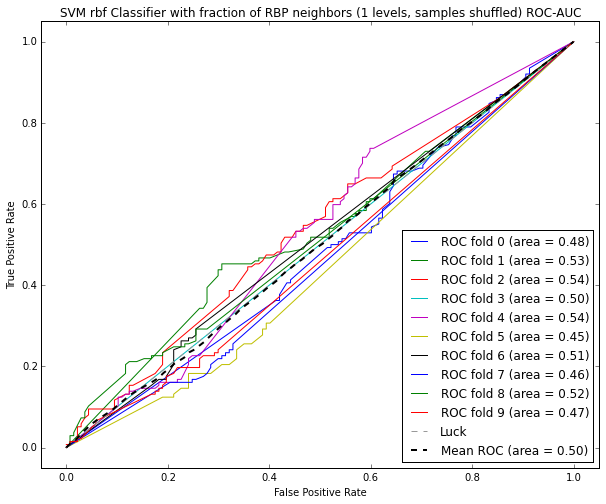

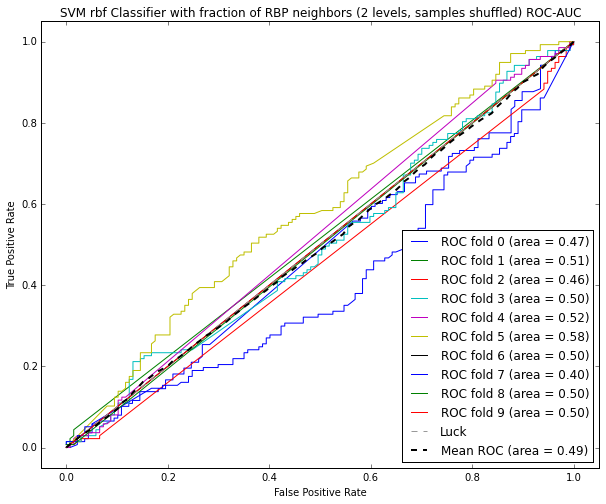

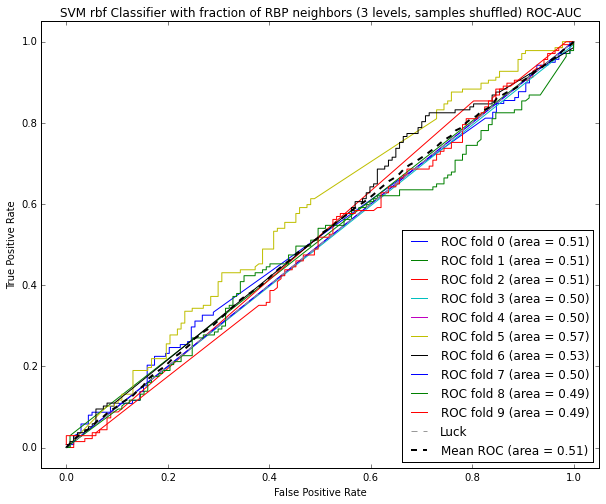

/projects/ps-yeolab/software/Anaconda_2.0.1_150511/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


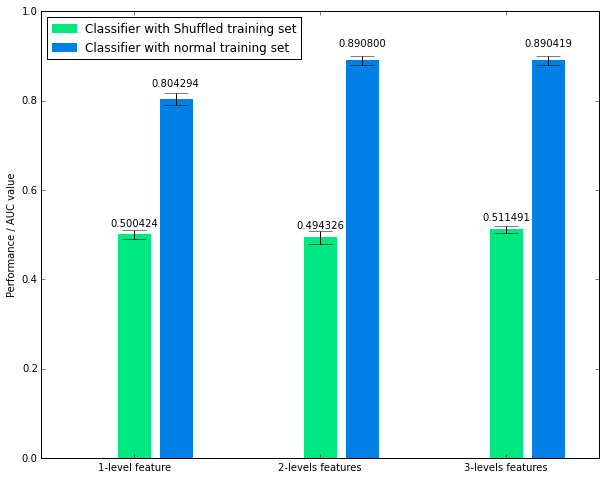

In [8]:
clf_SVM_ratio_1levels=svm.SVC(kernel= 'rbf', probability=True, class_weight={0:1,1:2.0})
auc_list_1level=draw_ROC_CV(X_ratio_undersampled_1level, y_undersampled, 10, clf_SVM_ratio_1levels, "SVM rbf Classifier with fraction of RBP neighbors (1 levels)")
clf_SVM_ratio_2levels=svm.SVC(kernel= 'rbf', probability=True, class_weight={0:1,1:2.0})
auc_list_2level=draw_ROC_CV(X_ratio_undersampled_2level, y_undersampled, 10, clf_SVM_ratio_2levels, "SVM rbf Classifier with fraction of RBP neighbors (2 levels)")
clf_SVM_ratio_3levels=svm.SVC(kernel= 'rbf', probability=True, class_weight={0:1,1:2.0})
auc_list_3level=draw_ROC_CV(X_ratio_undersampled_3level, y_undersampled, 10, clf_SVM_ratio_3levels, "SVM rbf Classifier with fraction of RBP neighbors(3 levels)")
clf_SVM_ratio_1levels_rand=svm.SVC(kernel= 'rbf', probability=True, class_weight={0:1,1:2.0})
auc_list_random_1level=draw_ROC_CV(X_ratio_undersampled_1level, y_undersampled_shuffled, 10, clf_SVM_ratio_1levels_rand, "SVM rbf Classifier with fraction of RBP neighbors (1 levels, samples shuffled)")
clf_SVM_ratio_2levels_rand=svm.SVC(kernel= 'rbf', probability=True, class_weight={0:1,1:2.0})
auc_list_random_2level=draw_ROC_CV(X_ratio_undersampled_2level, y_undersampled_shuffled, 10, clf_SVM_ratio_2levels_rand, "SVM rbf Classifier with fraction of RBP neighbors (2 levels, samples shuffled)")
clf_SVM_ratio_3levels_rand=svm.SVC(kernel= 'rbf', probability=True, class_weight={0:1,1:2.0})
auc_list_random_3level=draw_ROC_CV(X_ratio_undersampled_3level, y_undersampled_shuffled, 10, clf_SVM_ratio_3levels_rand, "SVM rbf Classifier with fraction of RBP neighbors (3 levels, samples shuffled)")
figure, ax=plt.subplots()
width=0.35
x_coord1=np.arange(1,6,2)
x_coord2=x_coord1+width+0.1
random_models=ax.bar(x_coord1,[np.mean(auc_list_random_1level),np.mean(auc_list_random_2level),np.mean(auc_list_random_3level)], width=width, yerr=[stats.sem(auc_list_random_1level),stats.sem(auc_list_random_2level),stats.sem(auc_list_random_3level)], color=(0,0.9,0.5), edgecolor=(0,0.9,0.5), align='center', ecolor='black', capsize=12)
models=ax.bar(x_coord2,[np.mean(auc_list_1level),np.mean(auc_list_2level),np.mean(auc_list_3level)], width=width, yerr=[stats.sem(auc_list_1level),stats.sem(auc_list_2level),stats.sem(auc_list_3level)], color=(0,0.5,0.9), edgecolor=(0,0.5,0.9), align='center', ecolor='black', capsize=12)
ax.set_xticks(range(1,6,2))
ax.set_xticklabels(['1-level feature', '2-levels features','3-levels features'])
ax.set_ylabel('Performance / AUC value')
ax.legend( (random_models[0], models[0]), ('Classifier with Shuffled training set', 'Classifier with normal training set') , loc='upper left')
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.03*height, '%f'%(height),
                ha='center', va='bottom')

autolabel(random_models)
autolabel(models)
figure.savefig('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/Figures/RBP_classifiers/AUC values of different classifiers1.pdf',format='pdf')
figure.savefig('AUC values of different classifiers1.pdf',format='pdf')

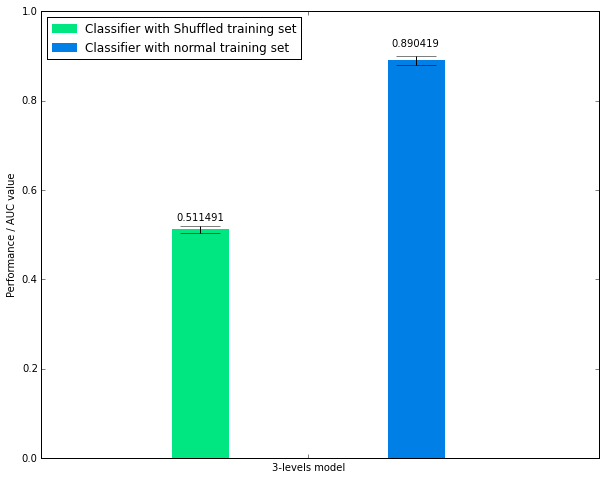

In [11]:
figure, ax=plt.subplots()
width=0.35
x_coord1=2
x_coord2=x_coord1+width+1
random_models=ax.bar(x_coord1,[np.mean(auc_list_random_3level)], width=width, yerr=[stats.sem(auc_list_random_3level)], color=(0,0.9,0.5), edgecolor=(0,0.9,0.5), align='center', ecolor='black', capsize=20)
models=ax.bar(x_coord2,[np.mean(auc_list_3level)], width=width, yerr=[stats.sem(auc_list_3level)], color=(0,0.5,0.9), edgecolor=(0,0.5,0.9), align='center', ecolor='black', capsize=20)
ax.set_xticks([2.5+0.5*width])
ax.set_xlim((1,4.5))
ax.set_xticklabels(['3-levels model'])
ax.set_ylabel('Performance / AUC value')
ax.legend((random_models[0], models[0]), ('Classifier with Shuffled training set', 'Classifier with normal training set') , loc='upper left')
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.03*height, '%f'%(height),
                ha='center', va='bottom')

autolabel(random_models)
autolabel(models)
figure.savefig('/home/wjin/Dropbox/RBP_identification_Kris_Wenhao/merged_list_figures/AUC values of 3-levels classifiers.pdf',format='pdf')
figure.savefig('AUC values of 3-levels classifiers.pdf',format='pdf')

<h2>Get sensitivity and specificity of the models</h2>

In [10]:
def get_metrics_of_classification(X, y, classifier, n_folds=10):
    cv=StratifiedKFold(y,n_folds=n_folds)
    sensitivity_list=[]
    specificity_list=[]
    for i, (train, test) in enumerate(cv):
        y_pred=classifier.fit(X[train], y[train]).predict(X[test])
        TP,TN,FP,FN = getCountsOf_TP_TN_FP_FN(y_pred, y[test])
        sensitivity=1.0*TP/(TP+FN)
        specificity=1.0*TN/(TN+FP)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
    
    return sensitivity_list, specificity_list
        

In [11]:
def getCountsOf_TP_TN_FP_FN(pred_labels, true_labels):
    """pred_labels and true_labels both are array or list of 0 and 1."""
    if(len(pred_labels)!=len(true_labels)):
        raise ValueError('The length of pred_labels and true_labels should be same!')
    
    TP=len([idx for idx in range(0, len(true_labels)) if true_labels[idx]==1 and pred_labels[idx]==1])
    TN=len([idx for idx in range(0, len(true_labels)) if true_labels[idx]==0 and pred_labels[idx]==0])
    FP=len([idx for idx in range(0, len(true_labels)) if true_labels[idx]==0 and pred_labels[idx]==1])
    FN=len([idx for idx in range(0, len(true_labels)) if true_labels[idx]==1 and pred_labels[idx]==0])
    return TP,TN,FP,FN

In [56]:
a=[0,1,1,0,1,0,0,1,0,1]
b=[1,1,1,0,0,1,1,1,0,0]
getCountsOf_TP_TN_FP_FN(a,b)

(3, 2, 2, 3)

In [74]:
def get_sensitivity_specificity(RBP_weight, X_list):
    clf=svm.SVC(kernel= 'rbf', class_weight={0:1,1:RBP_weight})
    figure,ax1=plt.subplots()
    figure.set_figheight(5)
    figure.set_figwidth(8)
    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax1.text(rect.get_x()+rect.get_width()/2., 1.03*height, '%0.3f'%(height),
                    ha='center', va='bottom')
        
    step = 0
    models=[]
    for X in X_list:
        sensitivity_list, specificity_list = get_metrics_of_classification(X, y_undersampled, clf, 10)
        step = step + 1
        model = ax1.bar([1+step, 5+step],[np.mean(sensitivity_list),np.mean(specificity_list)], color=(0,0.4+step*0.1, 0.0+step*0.3), width=0.6, yerr=[stats.sem(sensitivity_list),stats.sem(specificity_list)], align='center',ecolor='black', capsize=4)
        ax1.set_xlim((0,9))
        ax1.set_ylim((0,1))
        ax1.set_xticks([3, 7])
        ax1.set_xticklabels(['Sensitivity', 'Specificity'])
        ax1.set_title('class weights=1:'+str(RBP_weight)+' (RBP:nonRBP)')
        ax1.set_ylabel('AUC value')
        autolabel(model)
        models.append(model)
    
    ax1.legend((model[0] for model in models), ('1 Level NB', '2 Levels NB', '3 Levels NB') , loc='upper left', fontsize=9)


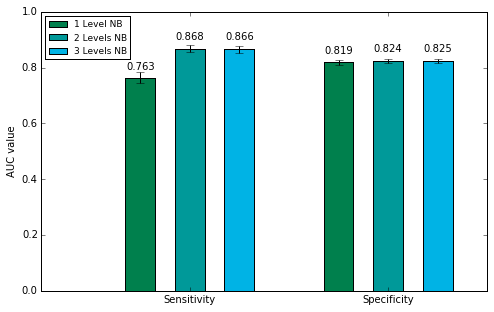

In [73]:
get_sensitivity_specificity(2, [X_ratio_undersampled_1level, X_ratio_undersampled_2level, X_ratio_undersampled_3level])